# Multi-Layer Perceptron for binary-classification in pytorch

Developing a two hidden layers MLP to perform **binary classification**.

We will use a MLP with 2 hidden layer with $n_{h1}=20$ and $n_{h2}=10$ hidden units and `relu` activation functions.

In [1]:
# Importing useful modules and packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sn
sn.set()

In [2]:
print(torch.__version__)

1.3.1


## Dataset

We take the usual circle dataset from sklearn.

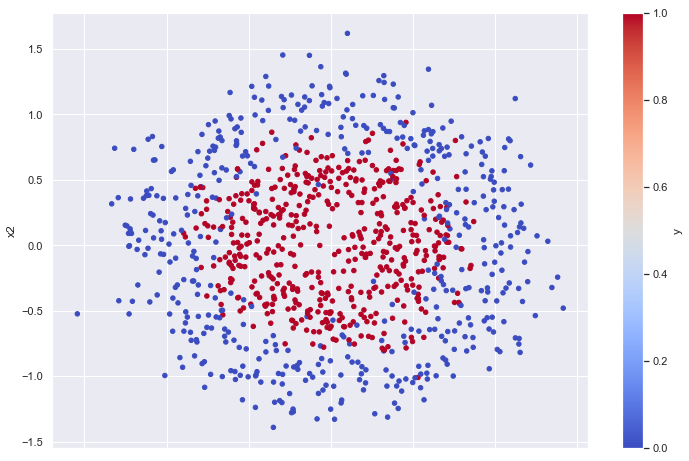

In [3]:
from sklearn import datasets
X_np, y_np = datasets.make_circles(n_samples=1000, noise=0.2, factor=0.5)

data = {'x1': X_np[:,0], 'x2': X_np[:,1], 'y': y_np}
data_df = pd.DataFrame(data)

data_df.plot.scatter(x='x1', y='x2', c='y', colormap='coolwarm', figsize=(12,8))

In [4]:
# Convertion to torch tensors
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()
y = y.view(len(y), 1)

print(X.size())
print(y.size())
print(X.mean(dim=0))
print(X.std(dim=0))

# Normalization
X -= X.mean(dim=0)
X /= X.std(dim=0)
print('--- Normalization ---')
print(X.mean(dim=0))
print(X.std(dim=0))

torch.Size([1000, 2])
torch.Size([1000, 1])
tensor([0.0026, 0.0070])
tensor([0.6010, 0.6042])
--- Normalization ---
tensor([1.2636e-08, 1.3828e-08])
tensor([1., 1.])


## Hyper-parameters

In [5]:
n_in = X.shape[1]
n_h1 = 20
n_h2 = 10
n_out = 1

nb_epoch = 10000
alpha = 0.1

## Model 1 (writing the network equations)
Manually defining the parameters `W1,b1,W2,b2,W3,b3` writing the forward equations, writting the loss equation, calling the `.backward()` and manually updating the weights using `W1.grad`.

In [6]:
# Initialization of the variables of the network (W1, b1, ...)
W1 = torch.tensor(np.random.rand(n_in, n_h1) * 0.01).float()
W1.requires_grad = True
b1 = torch.tensor(np.zeros(shape=(1, n_h1))).float()
b1.requires_grad = True

W2 = torch.tensor(np.random.rand(n_h1, n_h2) * 0.01).float()
W2.requires_grad = True
b2 = torch.tensor(np.zeros(shape=(1, n_h2))).float()
b2.requires_grad = True

W3 = torch.tensor(np.random.rand(n_h2, n_out) * 0.01).float()
W3.requires_grad = True
b3 = torch.tensor(np.zeros(shape=(1, n_out))).float()
b3.requires_grad = True

# Forward pass model
def model(X):
    A0 = X   
    Z1 = torch.mm(A0, W1) + b1
    A1 = F.relu(Z1)
    Z2 = torch.mm(A1, W2) + b2
    A2 = F.relu(Z2)
    Z3 = torch.mm(A2, W3) + b3
    A3 = torch.sigmoid(Z3)
    hat_y = A3
    
    return hat_y

### Training for model 1

In [7]:
train_cost = []

for num_epoch in range(0, nb_epoch):    

    # Forward pass
    hat_y = model(X)

    # -- We clip hat_y in order to avoid log(0)
    eps = 1e-10
    hat_y = torch.clamp(hat_y, eps, 1-eps)
    
    # Loss/cost
    # Binary cross entropy loss function
    loss = -(y*torch.log(hat_y) + (1 - y)*torch.log(1 - hat_y))
    cost = torch.mean(loss)
    
    train_cost.append(cost)

    # Backward
    cost.backward()
    
    # Update parameters
    with torch.no_grad():
        W1 -= alpha*W1.grad
        b1 -= alpha*b1.grad
        W2 -= alpha*W2.grad
        b2 -= alpha*b2.grad
        W3 -= alpha*W3.grad
        b3 -= alpha*b3.grad

    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    W3.grad.zero_()
    b3.grad.zero_()

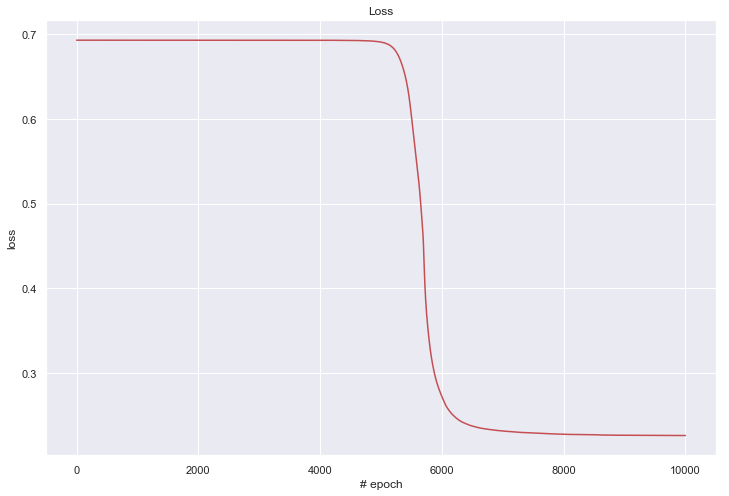

In [8]:
plt.figure(figsize=(12,8))
plt.title('Loss')
plt.plot(train_cost, 'r')
plt.xlabel('# epoch')
plt.ylabel('loss')
plt.show()

## Model 2 (using nn.sequential)
Using the `Sequential` class of pytorch.

In [9]:
model_2 = nn.Sequential(nn.Linear(n_in, n_h1, bias=True), nn.ReLU(),
                         nn.Linear(n_h1, n_h2, bias=True), nn.ReLU(),
                         nn.Linear(n_h2, n_out, bias=True), nn.Sigmoid())

## Model 3 (using a class definition)
Using custom `torch.nn.Module` class.

In [10]:
class Net(torch.nn.Module):
    def __init__(self, n_in, n_h1, n_h2, n_out):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in, n_h1, bias=True) # hidden layer 1
        self.fc2 = nn.Linear(n_h1, n_h2, bias=True) # hidden layer 2
        self.fc3 = nn.Linear(n_h2, n_out, bias=True)  # output layer
        
    def forward(self, X):
        
        A0 = X
        A1 = F.relu(self.fc1(A0))   # activation function for hidden layer 1
        A2 = F.relu(self.fc2(A1))   # activation function for hidden layer 2
        A3 = torch.sigmoid(self.fc3(A2))   # activation function for output layer
        
        return A3

model_3 = Net(n_in, n_h1, n_h2, n_out)

## Training for model 2 and 3

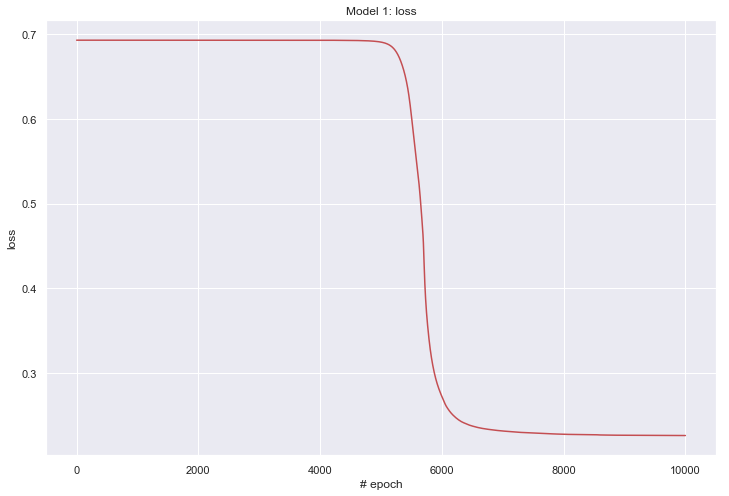

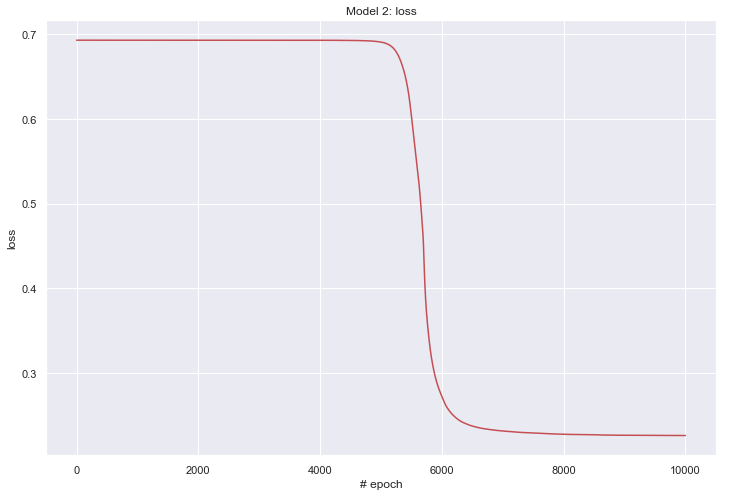

In [11]:
models = [model_2, model_3]

for i in range(len(models)):
    
    # Criterion and Optimization
    criterion = nn.BCELoss()
    optimizer = optim.SGD(models[i].parameters(), lr=0.01, momentum=0.9)
    
    loss_l = []
    for num_epoch in range(nb_epoch):

        # Forwad pass through model
        hat_y = models[i](X)
        # BCE Loss
        loss = criterion(hat_y, y)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

        loss_l.append(loss)

    plt.figure(figsize=(12,8))
    plt.title('Model {}: loss'.format(i+1))
    plt.plot(train_cost, 'r')
    plt.xlabel('# epoch')
    plt.ylabel('loss')
    plt.show()      